# 2022 NYC Open Data Week
# Civic Analytics using Open Data

https://www.urbanintelligencelab.org \ https://github.com/UrbanIntelligenceLab \ @UrbanIntelLab

In [1]:
import pandas as pd
import numpy as np
from urllib.parse import urlencode
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Access and Query 311 Data using Socrata Open API 1
## Goal 1: Access 311 data for multiple cities without downloading
### 1) Access NYC 311 data using Socrata API
* You can find Socrata API endpoint on the Open Data webpage.
![screenshot](../image/nyc_open_data_screenshot.png)

In [2]:
# Define API endpoint
API = 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv?'

# Get a data header
query = {'$select': '*',
        }
df = pd.read_csv(API+urlencode(query), parse_dates=['created_date'])
print (len(df))
df.head()

1000


,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,53578919,2022-03-07 02:06:22,NaN,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11213.0,953 PARK PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.673206,-73.946033,"\n, \n(40.67320572195818, -73.94603309965663)"
1,53579950,2022-03-07 02:05:59,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10473.0,303 BRONX RIVER AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.812854,-73.863633,"\n, \n(40.81285372764842, -73.8636327530249)"
2,53578911,2022-03-07 02:05:08,NaN,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,11432.0,177-03 JAMAICA AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.707940,-73.783742,"\n, \n(40.70793968594897, -73.7837419821809)"
3,53572773,2022-03-07 02:04:58,NaN,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Club/Bar/Restaurant,10462.0,900 MORRIS PARK AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.846702,-73.859324,"\n, \n(40.84670189123041, -73.85932366028462)"
4,53577980,2022-03-07 02:04:47,NaN,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10461.0,1315 COMMERCE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.835978,-73.840157,"\n, \n(40.8359780340985, -73.84015690731013)"


### 2) Show header with selected columns

In [3]:
# 'created_date', 'agency', 'complaint_type', 'location_type', 'incident_zip', 'latitude', 'longitude'

# Get a data header
query = {'$select': 'created_date, agency, complaint_type, location_type, incident_zip, latitude, longitude',
        }
df = pd.read_csv(API+urlencode(query), parse_dates=['created_date'])
df.head()

,created_date,agency,complaint_type,location_type,incident_zip,latitude,longitude
0,2019-09-17 22:35:28,NYPD,Noise - Residential,Residential Building/House,10454.0,40.806022,-73.927612
1,2021-06-28 17:11:00,DEP,Water System,NaN,10457.0,40.848385,-73.905951
2,2021-06-28 14:10:00,DEP,Water System,NaN,11228.0,40.618369,-74.005853
3,2021-06-28 12:31:00,DEP,Water System,NaN,10452.0,40.831362,-73.927848
4,2021-06-28 21:44:00,DEP,Water System,NaN,10452.0,40.840791,-73.914010


### 3) Count complaint volume
* Total number of 311 complaints since 2010
* Yearly counts of 311 complaints
* Montly counts of 311 complaints in 2021

In [4]:
# Total volume since 2010
query = {'$select': 'count(*)',
         }
df = pd.read_csv(API+urlencode(query))
df.head()

,count
0,27922740


In [5]:
# Yearly counts
query = {'$select': 'date_trunc_y(created_date) as year, count(*) as yearly_count',
         '$group': 'year',
        }
df = pd.read_csv(API+urlencode(query), parse_dates=['year'])
df.head()

,year,yearly_count
0,2010-01-01,2031813
1,2011-01-01,1961598
2,2012-01-01,1796169
3,2013-01-01,1839972
4,2014-01-01,2113991


In [6]:
# Monthly counts of 311 complaints in 2021
query = {'$select': 'date_trunc_ym(created_date) as month, count(*) as monthly_count',
         '$where': 'created_date between "2021-01-01" and "2021-12-31"',
         '$group': 'month',
        }
df = pd.read_csv(API+urlencode(query), parse_dates=['month'])
df.sort_values(by='month').head()

,month,monthly_count
9,2021-01-01,200057
4,2021-02-01,176834
11,2021-03-01,216379
1,2021-04-01,210531
0,2021-05-01,242449


## Goal 2: Count 311 service requests for multiple cities
### 4) Apply to multi-city 311 data to retrieve a total number of 311 complaints since data has been collected

In [7]:
# Socrata API endpoint for each city should be collected first. Here, we use a pre-collected table for 6 cities.
# New York, Chicago, Montgomery, San Francisco, Austin, and Baltimore

city_list = pd.read_csv('../data/example_cities_socrata.csv')
city_list[['city_state', 'Year','api_url', 'unique_column', 'date_column']].head()

,city_state,Year,api_url,unique_column,date_column
0,"NEW YORK CITY, NEW YORK",all,https://data.cityofnewyork.us/resource/erm2-nw...,unique_key,created_date
1,"CHICAGO CITY, ILLINOIS",all,https://data.cityofchicago.org/resource/v6vf-n...,sr_number,created_date
2,"MONTGOMERY, MARYLAND",all,https://data.montgomerycountymd.gov/resource/x...,sr_num,created
3,"SAN FRANCISCO CITY, CALIFORNIA",all,https://data.sfgov.org/resource/vw6y-z8j6.csv,service_request_id,requested_datetime
4,"AUSTIN CITY, TEXAS",all,https://data.austintexas.gov/resource/xwdj-i9h...,sr_number,sr_created_date


### 5) Create a summary table with total counts of complaints (overlapping period)

In [8]:
# Use for loops to count 311 complaint volumes for each city

cities = []
com_vol_ovpr = []

for i in range(len(city_list)):
    try:  
        query = {'$select': 'count(*)',
                 '$where': '%s between "2021-01-01" and "2021-12-31"'%(city_list['date_column'].iloc[i]),
                }
        df = pd.read_csv(city_list['api_url'].iloc[i]+'?'+urlencode(query))
        com_vol_ovpr.append(df.values[0][0])
        cities.append(city_list['city'].iloc[i])
    
    except:
        pass
print ("Processing completed")

result = pd.DataFrame()
result['city'] = cities
result['com_vol_ovpr'] = com_vol_ovpr
result['com_vol_ovpr'] = result['com_vol_ovpr'].astype(float)

result

Processing completed


,city,com_vol_ovpr
0,NEW YORK,2752401.0
1,CHICAGO,1740178.0
2,MONTGOMERY,584173.0
3,SAN FRANCISCO,632330.0
4,AUSTIN,180870.0


## Goal 3: Create a plot to compare values across different cities
### 6) Create a bar chart (descending)

Text(0, 0.5, '311 Complaint Volume (total)')

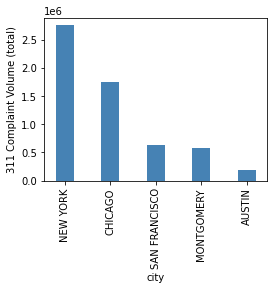

In [9]:
result.index = result['city']

fig = plt.figure(figsize=(4,3)) # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4
result.sort_values(by='com_vol_ovpr', ascending=False).com_vol_ovpr.plot(kind='bar', color='SteelBlue', ax=ax, width=width)
ax.set_ylabel('311 Complaint Volume (total)')

![bar_chart_multicity](../image/bar_chart_multicity.png)

# Access and Query 311 Data using Socrata Open API 2
## Goal 1: Access NYC 311 data and Count 2019 & 2020 citizen service requests
### 1) Access NYC 311 and compare 2019 & 2020 (pre-pandemic vs. post-pandemic) complatint volume

In [10]:
# Total complaints March 1, 2019 ~ June 30, 2019
query_2019 = {'$select': 'count(*) as total_count_2019',
         '$where': 'created_date between "2019-03-01" and "2019-06-30"',
        }
df_2019 = pd.read_csv(API+urlencode(query_2019))

# Total complaints March 1, 2020 ~ June 30, 2020 (Pandemic period)
query_2020 = {'$select': 'count(*) as total_count_2020',
         '$where': 'created_date between "2020-03-01" and "2020-06-30"',
        }
df_2020 = pd.read_csv(API+urlencode(query_2020))

df = pd.concat([df_2019, df_2020], axis=1)
df

,total_count_2019,total_count_2020
0,931834,773067


## Goal 2: Create plots to understand most reported complaint types
### 2) Create a plot - top 50 complaint types (total)

In [12]:
DATE_CONDITION = 'created_date between "2020-02-01" and "2020-08-10"'

# get complaint volume
query = {'$select': 'complaint_type, date_trunc_ymd(created_date) as date, count(*)',
         '$where': DATE_CONDITION,
         '$group': 'complaint_type, date',
         '$limit': 1000*1000,
        }
df = pd.read_csv(API+urlencode(query), parse_dates=['date'])
df.head()

,complaint_type,date,count
0,Noise - Park,2020-06-03,3
1,Recycling Enforcement,2020-04-15,1
2,Highway Sign - Damaged,2020-02-19,1
3,Mosquitoes,2020-06-21,3
4,HEAT/HOT WATER,2020-04-21,409


In [13]:
df = df.pivot_table(index='date', columns='complaint_type', values='count', fill_value=0)
df.head()

complaint_type,APPLIANCE,Abandoned Vehicle,Air Quality,Animal Facility - No Permit,Animal in a Park,Animal-Abuse,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,WATER LEAK,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,4,103,10,0,4,12,5,0,0,0,...,2,0,5,3,15,4,2,108,0,0
2020-02-02,6,74,12,0,13,24,0,1,0,0,...,1,1,2,4,15,0,2,56,0,0
2020-02-03,33,158,23,2,3,26,5,1,0,0,...,2,4,6,6,44,12,3,153,0,0
2020-02-04,39,136,23,0,3,15,4,1,0,0,...,2,0,10,4,38,6,2,135,0,0
2020-02-05,23,128,14,0,5,22,8,2,1,1,...,1,0,8,2,31,7,2,145,0,0


In [14]:
truncated = df.sum(axis=0).sort_values(ascending=False).head(50)
truncated[:5]

complaint_type
Noise - Residential            210919
Noise - Street/Sidewalk        121275
Illegal Parking                 84020
Non-Emergency Police Matter     77472
HEAT/HOT WATER                  60703
dtype: int64

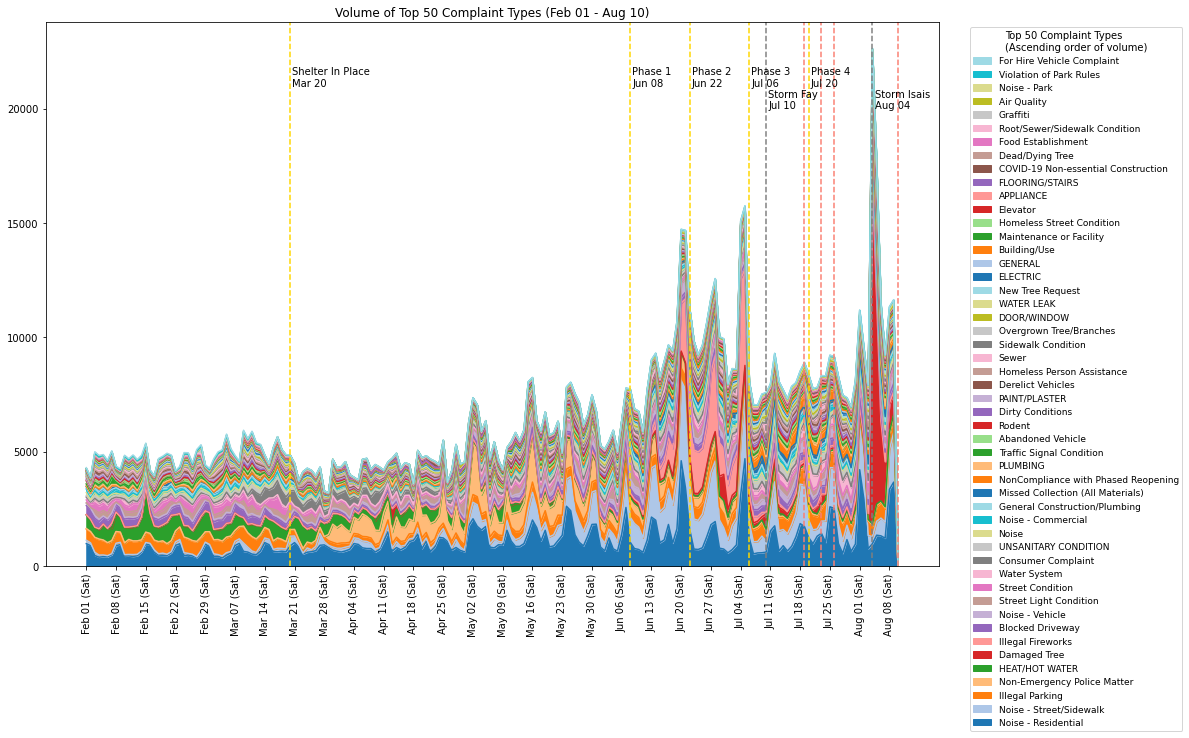

In [15]:
temp = df[truncated.index].copy().reset_index(drop=True)
ax = temp.plot.area(stacked=True, figsize=(16,10), 
                    title='Volume of Top 50 Complaint Types (Feb 01 - Aug 10)',
                    cmap=ListedColormap(list(cm.get_cmap('tab20').colors)*3))
# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], 
          title='Top 50 Complaint Types\n(Ascending order of volume)', 
          fontsize=9,
          bbox_to_anchor=(1.03,1))

# date labels
x_indices = range(0, len(temp.index), 7)
date_index = df[truncated.index].index
x_labels = date_index.strftime('%h %d (%a)').tolist()
ax.set_xticks(x_indices)
_ = ax.set_xticklabels([x_labels[i] for i in x_indices], rotation=90)


### annotation
# annotate covid dates
dates = {
    '2020-03-20': 'Shelter In Place',
    '2020-06-08': 'Phase 1',
    '2020-06-22': 'Phase 2',
    '2020-07-06': 'Phase 3',
    '2020-07-20': 'Phase 4',
}
annotation = [(i, date) for i, date in enumerate(date_index.strftime('%Y-%m-%d').tolist()) 
     if date in dates]
for annot_i, annot_text in annotation: 
    ax.axvline(annot_i, color='gold', linestyle='--')
    ax.text(x=annot_i+.5, y=21000, s='%s\n%s'%(dates[annot_text], 
                                               date_index[annot_i].strftime('%h %d')))
    
# annotate storm dates
dates = ['2020-07-10', '2020-08-04']
date_labels = ['Storm Fay', 'Storm Isais']
annotation = [i for i, date in enumerate(date_index.strftime('%Y-%m-%d').tolist()) if date in dates]
for i, date_i in enumerate(annotation): 
    ax.axvline(date_i, color='grey', linestyle='--')
    ax.text(x=date_i+.5, y=20000, s='%s\n%s'%(date_labels[i], 
                                               date_index[date_i].strftime('%h %d')))

# annotate heat advisory dates
dates = ['2020-07-19', '2020-07-23', '2020-07-26', '2020-08-10']
annotation = [i for i, date in enumerate(date_index.strftime('%Y-%m-%d').tolist()) if date in dates]
for i, date_i in enumerate(annotation): 
    ax.axvline(date_i, color='salmon', linestyle='--')

### 3) Create a plot - top 50 complaint types (stacked proportional)

In [16]:
# Calauclate proportional values for each complaint type
temp = df[truncated.index].copy()
temp = temp.div(df[truncated.index].sum(axis=1), axis=0)
temp.head()

complaint_type,Noise - Residential,Noise - Street/Sidewalk,Illegal Parking,Non-Emergency Police Matter,HEAT/HOT WATER,Damaged Tree,Illegal Fireworks,Blocked Driveway,Noise - Vehicle,Street Light Condition,...,FLOORING/STAIRS,COVID-19 Non-essential Construction,Dead/Dying Tree,Food Establishment,Root/Sewer/Sidewalk Condition,Graffiti,Air Quality,Noise - Park,Violation of Park Rules,For Hire Vehicle Complaint
date,,,,,,,,,,,,,,,,,,,,,
2020-02-01,0.228213,0.034395,0.114106,0.005113,0.137578,0.003021,0.000232,0.092029,0.022078,0.007669,...,0.001394,0.0,0.001394,0.003951,0.001394,0.003486,0.002324,0.001162,0.000697,0.009063
2020-02-02,0.228959,0.031466,0.123305,0.003326,0.134050,0.001791,0.000256,0.110258,0.015605,0.005628,...,0.000000,0.0,0.001279,0.007930,0.001535,0.005628,0.003070,0.000512,0.001023,0.009721
2020-02-03,0.092581,0.028794,0.126375,0.004199,0.082783,0.005999,0.000000,0.077984,0.023595,0.047191,...,0.002799,0.0,0.003199,0.006399,0.006799,0.005399,0.004599,0.000600,0.001200,0.013397
2020-02-04,0.080595,0.018599,0.139285,0.006613,0.083282,0.008473,0.000000,0.065716,0.019839,0.060963,...,0.002480,0.0,0.002893,0.007026,0.006613,0.004546,0.004753,0.000620,0.000827,0.014879
2020-02-05,0.084461,0.015170,0.128946,0.005740,0.138171,0.004305,0.000000,0.061296,0.011070,0.049610,...,0.001845,0.0,0.002255,0.011480,0.004715,0.007380,0.002870,0.000000,0.000410,0.006970


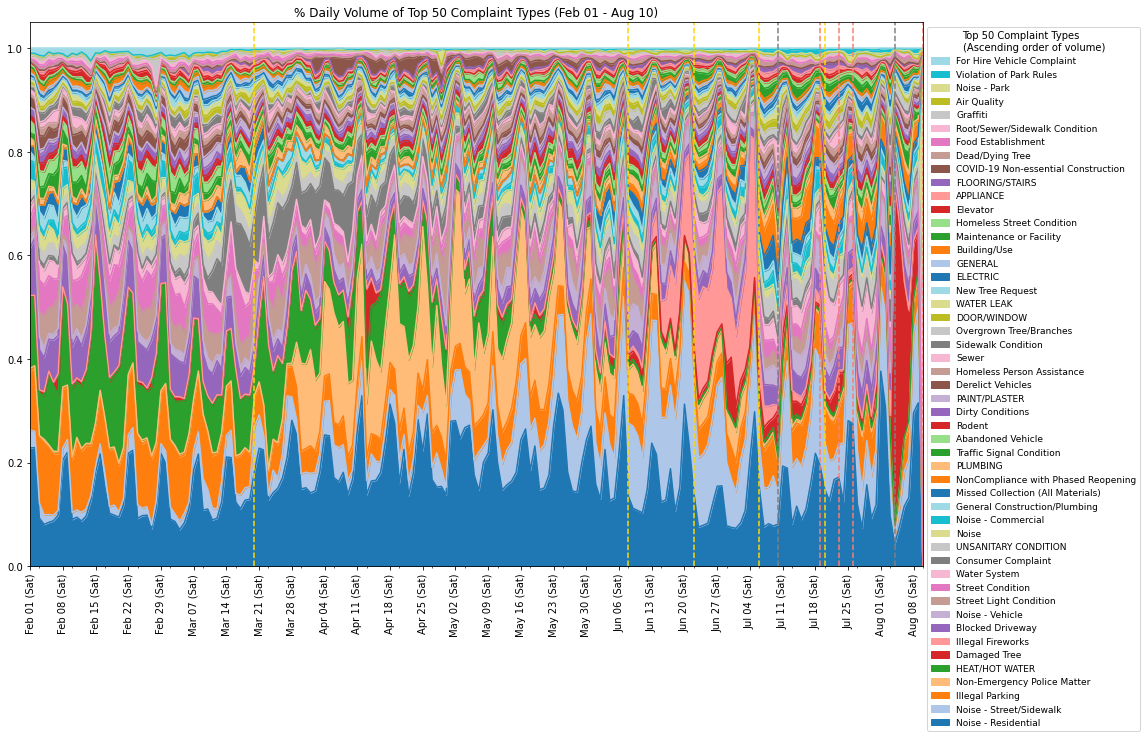

In [17]:
ax = temp.plot.area(stacked=True, figsize=(16,10), 
                    title='% Daily Volume of Top 50 Complaint Types (Feb 01 - Aug 10)',
                    cmap=ListedColormap(list(cm.get_cmap('tab20').colors)*3)
                   )
ax.set_xlabel('')
# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], 
          title='Top 50 Complaint Types\n(Ascending order of volume)', 
          fontsize=9,
          bbox_to_anchor=(1,1))

# date labels
x_indices = range(0, len(temp.index), 7)
ax.set_xticks(temp.index[x_indices])
_ = ax.set_xticklabels([d.strftime('%h %d (%a)') for d in temp.index[x_indices]], rotation=90)

### annotation
# annotate covid dates
dates = {
    '2020-03-20': 'Shelter In Place',
    '2020-06-08': 'Phase 1',
    '2020-06-22': 'Phase 2',
    '2020-07-06': 'Phase 3',
    '2020-07-20': 'Phase 4',
}
for date in dates: 
    ax.axvline(date, color='gold', linestyle='--')

# annotate storm dates
for date in ['2020-07-10', '2020-08-04']:
    ax.axvline(date, color='grey', linestyle='--')

# annotate heat advisory dates
for date in ['2020-07-19', '2020-07-23', '2020-07-26', '2020-08-10']:
    ax.axvline(date, color='salmon', linestyle='--')

## Goal 3: Understand social distancing complaints
### 4) Count a total number of social distancing complaints 

In [18]:
query = {'$select': 'count(*)',
         '$where': 'descriptor in("Social Distancing", "Face Covering Violation")', 
        }
df = pd.read_csv(API+urlencode(query))
df.head()

,count
0,75246


In [19]:
query = {'$select': 'min(created_date)',
         '$where': 'descriptor in("Social Distancing", "Face Covering Violation")', 
        }
df = pd.read_csv(API+urlencode(query))
df.head()

,min_created_date
0,2020-03-28T20:35:44.000


In [20]:
query = {'$select': 'max(created_date)',
         '$where': 'descriptor in("Social Distancing", "Face Covering Violation")', 
        }
df = pd.read_csv(API+urlencode(query))
df.head()

,max_created_date
0,2022-02-16T13:20:08.000


### 5) Create a plot - daily social distancing complaint counts

In [21]:
# Monthly counts of 311 complaints in 2021
query = {'$select': 'date_trunc_ymd(created_date) as date, count(*) as daily_counts',
         '$where': 'descriptor in("Social Distancing", "Face Covering Violation") and \
         created_date between "2020-03-28" and "2020-08-25"',
         '$group': 'date',
        }
df = pd.read_csv(API+urlencode(query), parse_dates=['date'])
df.index = df['date']
df.head()

,date,daily_counts
date,,
2020-03-28,2020-03-28,2
2020-03-29,2020-03-29,262
2020-03-30,2020-03-30,776
2020-03-31,2020-03-31,682
2020-04-01,2020-04-01,792


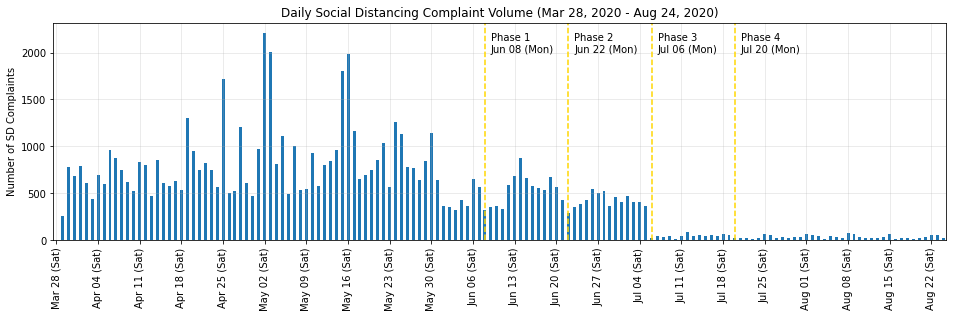

In [22]:
ax = df.daily_counts.plot.bar(figsize=(16,4))

# xlabels: print only once every week
xindices = list(range(0,len(df),7))
xlabels = df.index.strftime('%b %d (%a)')
ax.set_xticks(xindices)
ax.set_xticklabels(xlabels[xindices])
plt.xlabel('')

# Add annotations
dates = {
    '2020-03-20': 'Stay-at-home order',
    '2020-06-08': 'Phase 1',
    '2020-06-22': 'Phase 2',
    '2020-07-06': 'Phase 3',
    '2020-07-20': 'Phase 4',
}
annotation = [(i, date) for i, date in enumerate(df.index.strftime('%Y-%m-%d').tolist()) if date in dates]
for annot_i, annot_text in annotation: 
    ax.axvline(annot_i, color='gold', linestyle='--')
    ax.text(x=annot_i+1, y=2000, s='%s\n%s'%(dates[annot_text], 
                                               xlabels[annot_i]))

ax.grid(True, alpha=.3)
plt.ylabel('Number of SD Complaints')
min_date = df.index.min().strftime('%b %d')
max_date = df.index.max().strftime('%b %d')
_ = plt.title('Daily Social Distancing Complaint Volume (%s, 2020 - %s, 2020)'%(min_date, max_date))